# scenarios_all — SR parameterisation + **heuristics** + drop at **t = 15**

This notebook uses **one environment** and **three ignition points** chosen so each heuristic clearly shines:

- **Downwind blocking**
- **Uniform ring**
- **Value blocking**

**Key change:** retardant is applied at CA step **t = 15** (not at t=0).

We implement this by:
1) simulating the ignition forward **15 steps without retardant** to create the *decision-time* firestate, and
2) running heuristics / BO from that firestate.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fire_model.ca import FireEnv, CAFireModel
from fire_model.bo_sr import RetardantDropBayesOptSR, expected_improvement
np.set_printoptions(suppress=True, precision=3)

## One environment that can showcase all three heuristics

This is a single synthetic-but-structured environment:

- **Strong wind lane** on the left → downwind blocking should look best.
- **Calm basin** in the middle → uniform ring looks best.
- **High-value town + corridor** in the NE → value blocking looks best.

We also create simple **roads / river / riparian** masks for report-style overlays.


In [4]:
# --- Environment builder ---

def _smooth_field(rng, shape, iters=6):
    field = rng.normal(size=shape)
    smooth = field.copy()
    for _ in range(iters):
        smooth = (
            0.40 * smooth
            + 0.10 * np.roll(smooth, 1, 0) + 0.10 * np.roll(smooth, -1, 0)
            + 0.10 * np.roll(smooth, 1, 1) + 0.10 * np.roll(smooth, -1, 1)
            + 0.05 * np.roll(np.roll(smooth, 1, 0), 1, 1)
            + 0.05 * np.roll(np.roll(smooth, -1, 0), -1, 1)
            + 0.05 * np.roll(np.roll(smooth, 1, 0), -1, 1)
            + 0.05 * np.roll(np.roll(smooth, -1, 0), 1, 1)
        )
    smooth = (smooth - smooth.mean()) / (smooth.std() + 1e-9)
    return smooth


def _distance_to_curve(xgrid, ygrid, pts):
    dmin = np.full(xgrid.shape, np.inf, dtype=float)
    for px, py in pts:
        d = np.sqrt((xgrid - px) ** 2 + (ygrid - py) ** 2)
        dmin = np.minimum(dmin, d)
    return dmin


def make_env_all_heuristics_showcase(
    *,
    grid_size=(240, 240),
    domain_km=12.0,
    dt_s=30.0,
    ros_mps=0.9,
    seed=21,
):
    nx, ny = grid_size
    dx_m = (domain_km / nx) * 1000.0

    xs = np.linspace(-3.0, 3.0, nx)[:, None]
    ys = np.linspace(-3.0, 3.0, ny)[None, :]
    X = xs.repeat(ny, axis=1)
    Y = ys.repeat(nx, axis=0)

    rng = np.random.default_rng(seed)

    # --- Terrain: ridge + basin + north rise ---
    smooth = _smooth_field(rng, (nx, ny), iters=5)
    ridge = 55.0 * np.exp(-((Y - (0.45 * X) - 0.4) ** 2) / 0.45)
    basin = -65.0 * np.exp(-(((X + 0.8) ** 2 + (Y + 0.5) ** 2) / 0.55))
    north_rise = 40.0 * (1.0 / (1.0 + np.exp(-(Y - 0.3) / 0.6)))

    elev_m = 160.0 + ridge + basin + north_rise + 12.0 * smooth
    elev_m = np.clip(elev_m, 70.0, 340.0)

    # --- River: east-west meander ---
    rt = np.linspace(-3.0, 3.0, 260)
    river_y0 = -1.05
    river_y = river_y0 + 0.25 * np.sin(0.75 * rt) + 0.10 * np.sin(2.2 * rt)
    river_x = rt
    river_pts = np.stack([river_x, river_y], axis=1)
    d_river = _distance_to_curve(X, Y, river_pts)

    river_mask = d_river < 0.045
    riparian_mask = d_river < 0.12

    elev_m = elev_m - 10.0 * np.exp(-(d_river ** 2) / (2 * 0.030 ** 2))
    elev_m = np.clip(elev_m, 70.0, 340.0)

    # --- Lake (SE) ---
    lake_mask = ((X - 1.6) ** 2) / (0.45 ** 2) + ((Y + 1.6) ** 2) / (0.35 ** 2) < 1.0

    dzdx = np.gradient(elev_m, dx_m, axis=0)
    dzdy = np.gradient(elev_m, dx_m, axis=1)
    slope = np.stack([dzdx, dzdy], axis=-1)
    slope_deg = np.degrees(np.arctan(np.sqrt(dzdx ** 2 + dzdy ** 2)))

    # --- Roads ---
    road_mask = np.zeros((nx, ny), dtype=bool)

    # North-south highway near center-west
    hw_pts = np.stack([ -0.4 + 0.12 * np.sin(0.6 * rt), rt ], axis=1)
    d_hw = _distance_to_curve(X, Y, hw_pts)
    road_mask |= d_hw < 0.05

    # East-west arterial in the north
    t2 = np.linspace(-3.0, 3.0, 220)
    ew_pts = np.stack([ t2, 1.1 + 0.18 * np.sin(0.9 * t2) ], axis=1)
    d_ew = _distance_to_curve(X, Y, ew_pts)
    road_mask |= d_ew < 0.045

    # --- Towns ---
    flat = slope_deg < 6.0
    not_water = (~river_mask) & (~lake_mask)

    cand0 = flat & not_water & (Y > -0.2) & (Y < 1.6) & (X < 0.6)
    cand1 = flat & not_water & (Y < -0.6) & (X > 0.6)

    def pick_town(mask, prefer_x, prefer_y=0.0):
        score = mask.astype(float)
        score *= np.exp(-(slope_deg ** 2) / (2 * 4.0 ** 2))
        score *= np.exp(-((Y - prefer_y) ** 2) / (2 * 0.60 ** 2))
        score *= np.exp(-((X - prefer_x) ** 2) / (2 * 0.80 ** 2))
        i, j = np.unravel_index(np.argmax(score), score.shape)
        return (i, j)

    town0 = pick_town(cand0, prefer_x=-0.3, prefer_y=0.7)
    town1 = pick_town(cand1, prefer_x=1.4, prefer_y=-1.2)

    near_hw = d_hw < 0.12
    cand_small = flat & not_water & near_hw & (Y > 1.2)
    small_town = pick_town(cand_small, prefer_x=-0.5, prefer_y=1.6)

    town_centers = [town0, town1, small_town]

    # --- Fuels ---
    fuel = 0.9 * np.ones((nx, ny), dtype=float)
    upland_fuel = 1.0 * (1.0 - np.exp(-((Y - 0.2) ** 2) / 1.2))
    fuel += upland_fuel

    patch = _smooth_field(rng, (nx, ny), iters=4)
    fuel *= (1.0 + 0.08 * patch)

    fuel *= np.where(road_mask, 0.07, 1.0)
    fuel *= np.where(river_mask, 0.03, 1.0)
    fuel *= np.where(riparian_mask & (~river_mask), 0.75, 1.0)
    fuel *= np.where(lake_mask, 0.0, 1.0)
    fuel = np.clip(fuel, 0.05, 3.0)
    fuel[river_mask] = 0.0

    # --- Values-at-risk ---
    value = np.ones((nx, ny), dtype=float)

    def add_town_value(center, core_amp, core_sigma, wui_amp, wui_sigma):
        ti, tj = center
        cx = xs[ti, 0]
        cy = ys[0, tj]
        r2 = (X - cx) ** 2 + (Y - cy) ** 2
        return core_amp * np.exp(-r2 / core_sigma) + wui_amp * np.exp(-r2 / wui_sigma)

    value += add_town_value(town0, core_amp=9.0, core_sigma=0.10, wui_amp=3.0, wui_sigma=0.30)
    value += add_town_value(town1, core_amp=8.0, core_sigma=0.09, wui_amp=2.6, wui_sigma=0.26)
    value += add_town_value(small_town, core_amp=4.5, core_sigma=0.08, wui_amp=1.8, wui_sigma=0.22)

    value += 0.6 * road_mask.astype(float)
    value += 0.9 * (riparian_mask & (~river_mask)).astype(float)

    # --- Wind (steady southerly with local acceleration) ---
    wind = np.zeros((nx, ny, 2), dtype=float)
    base_u, base_v = 1.2, 3.8  # S -> N with slight easterly
    wind[..., 0] = base_u
    wind[..., 1] = base_v

    accel = np.exp(-0.5 * (((X + 1.1) / 0.8) ** 2 + ((Y + 0.9) / 0.7) ** 2))
    wind[..., 1] *= (1.0 + 0.45 * accel)

    wind = np.clip(wind, -8.0, 8.0)

    env = FireEnv(
        grid_size=grid_size,
    domain_km=12.0,
        fuel=fuel,
        value=value,
        wind=wind,
        slope=slope,
        dt_s=dt_s,
        ros_mps=ros_mps,
        wind_coeff=0.05,
        burn_time_s0=900.0,
        drop_w_km=0.5,
        drop_h_km=0.9,
        drop_amount=2.0,
        retardant_half_life_s=3600.0 * 10,
        retardant_k=20.0,
        diag=True,
        avoid_burning_drop=True,
        avoid_drop_p_threshold=0.25,
    )

    overlays = dict(
        road_mask=road_mask,
        river_mask=river_mask,
        riparian_mask=riparian_mask,
        town_centers=town_centers,
    )
    return env, overlays


env, overlays = make_env_all_heuristics_showcase()
print('grid:', env.grid_size, 'domain_km:', env.domain_km, 'dt_s:', env.dt_s)



grid: (240, 240) domain_km: 12.0 dt_s: 30.0


## Ignitions (same environment)

We pick three ignition points on the *same* environment, each designed to highlight one heuristic.


In [5]:
nx, ny = env.grid_size

IGNITIONS = {
    # In the strong wind lane, upwind of the east asset
    'downwind_blocking': (int(0.20 * nx), int(0.50 * ny)),

    # In the calm basin near the center
    'uniform_ring': (int(0.50 * nx), int(0.50 * ny)),

    # SW of the corridor + town (NE)
    'value_blocking': (int(0.48 * nx), int(0.42 * ny)),
}

IGNITIONS


{'downwind_blocking': (48, 120),
 'uniform_ring': (120, 120),
 'value_blocking': (115, 100)}

## Decision-time drop: advance to t=15 (no retardant)

We create the *decision-time* initial firestate by simulating **15 CA steps** forward.


In [6]:
DROP_STEP = 15  # <-- required by you

# Keep these consistent across methods
EVOLUTION_TIME_S = 60 * 60
SEARCH_GRID_EVO_TIME_S = 10 * 60
N_DRONES = 5
N_SIMS_LOW = 6
IGNITION_RADIUS_KM = 0.25
SEED = 0


def advance_state_no_drop(model: CAFireModel, state, steps: int):
    # Advance MC batch forward without any retardant
    for _ in range(int(steps)):
        model.step_batch(
            state,
            ros_mps=model.env.ros_mps,
            wind_coeff=model.env.wind_coeff,
            diag=model.env.diag,
        )
    return state


def make_opt_sr_for_ignition(ignition_center, *, seed=0):
    model = CAFireModel(env, seed=seed)

    init_state = model.init_state_batch(
        n_sims=N_SIMS_LOW,
        center=ignition_center,
        radius_km=IGNITION_RADIUS_KM,
    )

    # --- IMPORTANT: move to decision time ---
    init_state = advance_state_no_drop(model, init_state, DROP_STEP)

    opt = RetardantDropBayesOptSR(
        fire_model=model,
        init_firestate=init_state,
        n_drones=N_DRONES,
        evolution_time_s=EVOLUTION_TIME_S,
        n_sims=N_SIMS_LOW,
        fire_boundary_probability=0.25,
        search_grid_evolution_time_s=SEARCH_GRID_EVO_TIME_S,
        rng=np.random.default_rng(seed),
    )
    return opt

print('DROP_STEP =', DROP_STEP, '=> drop_time_s =', DROP_STEP * env.dt_s)


DROP_STEP = 15 => drop_time_s = 450.0


## BO loop (SR)

This is the same SR BO loop as before, but we will use it mainly for **small sanity runs**.
The main focus below is validating that each heuristic works properly at **t=15**.


In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from tqdm.auto import tqdm


def run_bayes_opt_sr(
    opt: RetardantDropBayesOptSR,
    *,
    n_init=10,
    n_iters=10,
    n_candidates=2500,
    xi=0.01,
    K_grid=320,
    boundary_field="affected",
    init_strategy="heuristic",  # random | random_mask | uniform_ring | downwind_line | heuristic
    init_heuristic_kwargs=None,
    candidate_strategy="mixed",  # qmc | random_mask | mixed
    candidate_qmc="sobol",
    candidate_local_frac=0.65,
    candidate_local_top_k=3,
    candidate_local_sigma_s=0.05,
    candidate_local_sigma_r=0.05,
    candidate_local_sigma_delta_rad=np.deg2rad(12.0),
    candidate_local_resample_delta_prob=0.05,
    use_ard_kernel=False,
    seed=0,
):
    rng = np.random.default_rng(seed)

    # Reset cached SR masks to avoid K-mismatch across runs
    opt.sr_valid_mask = None
    opt.sr_valid_indices = None
    opt.sr_index_tree = None

    # SR grid required for decode & mask sampling
    opt.setup_search_grid_sr(K=K_grid, boundary_field=boundary_field)

    init_heuristic_kwargs = init_heuristic_kwargs or {}
    if init_strategy == "random":
        thetas = opt.sample_qmc_theta(n_init, method=candidate_qmc)
    elif init_strategy == "random_mask":
        thetas = opt.sample_random_theta_on_mask(n_init)
    else:
        thetas = opt.sample_initial_thetas(
            n_init,
            strategy=init_strategy,
            heuristic_kwargs=init_heuristic_kwargs,
        )

    thetas = np.atleast_2d(thetas)
    X = np.stack([opt.theta_to_gp_features(th) for th in thetas], axis=0)
    y = np.array([opt.expected_value_burned_area(th) for th in tqdm(thetas, desc="BO init eval")], dtype=float)

    thetas_list = [th.copy() for th in thetas]
    y_best = float(np.min(y))
    best_theta = thetas_list[int(np.argmin(y))]

    dim = X.shape[1]
    matern = Matern(length_scale=np.ones(dim) if use_ard_kernel else 1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5)
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * matern + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-6, 1e2))

    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=2, random_state=None)

    hist = {"y_best": [y_best], "y_next": [], "theta_best": [best_theta.copy()]}

    for _ in tqdm(range(n_iters), desc="Bayesian optimisation"):
        gp.fit(X, y)

        cstrat = str(candidate_strategy).lower().strip()
        if cstrat in {"qmc", "random"}:
            cand = opt.sample_qmc_theta(n_candidates, method=candidate_qmc)
        elif cstrat == "random_mask":
            cand = opt.sample_random_theta_on_mask(n_candidates)
        elif cstrat == "mixed":
            n_local = int(np.round(n_candidates * float(np.clip(candidate_local_frac, 0.0, 1.0))))
            n_global = int(n_candidates - n_local)

            cand_g = opt.sample_random_theta_on_mask(n_global)

            top_idx = np.argsort(y)[: max(int(candidate_local_top_k), 1)]
            anchors = np.asarray([thetas_list[i] for i in top_idx])
            cand_l = opt.sample_local_theta(
                anchors,
                n_local,
                sigma_s=candidate_local_sigma_s,
                sigma_r=candidate_local_sigma_r,
                sigma_delta_rad=candidate_local_sigma_delta_rad,
                resample_delta_prob=candidate_local_resample_delta_prob,
            )

            cand = np.vstack([np.atleast_2d(cand_g), np.atleast_2d(cand_l)])
        else:
            raise ValueError(f"Unknown candidate_strategy={candidate_strategy}")

        cand = np.atleast_2d(cand)
        Xc = np.stack([opt.theta_to_gp_features(th) for th in cand], axis=0)

        # NOTE: expected_improvement from bo_sr expects (X, gp).
        mu, std = gp.predict(Xc, return_std=True)
        ei = expected_improvement(Xc, gp, y_best, xi=xi)
        idx = int(np.argmax(ei))

        theta_next = cand[idx]
        y_next = float(opt.expected_value_burned_area(theta_next))

        thetas_list.append(theta_next.copy())
        X = np.vstack([X, Xc[idx:idx+1]])
        y = np.append(y, y_next)

        if y_next < y_best:
            y_best = y_next
            best_theta = theta_next.copy()

        hist["y_best"].append(float(y_best))
        hist["y_next"].append(float(y_next))
        hist["theta_best"].append(best_theta.copy())

    return best_theta, hist


## Report-style visualisation (with drop at t=15)

We simulate step-by-step and apply the retardant rectangle(s) at **exactly t=15**.


In [20]:
def simulate_with_drop_step(
    model: CAFireModel,
    ignition_center,
    *,
    n_sims,
    ignition_radius_km,
    T_s,
    drop_step,
    drone_params_xyphi=None,
    seed=0,
    dt_snapshot_s=5*60,
):
    # Build initial batch
    state = model.init_state_batch(n_sims=n_sims, center=ignition_center, radius_km=ignition_radius_km)

    dt_s = float(model.env.dt_s)
    total_steps = int(np.ceil(float(T_s) / dt_s))

    # snapshot steps
    snap_times = np.arange(0, T_s + 1e-9, dt_snapshot_s, dtype=float)
    if snap_times[-1] < T_s:
        snap_times = np.append(snap_times, T_s)
    snap_steps = set(int(round(t / dt_s)) for t in snap_times)

    snaps = []

    # Step through time
    for step in range(total_steps + 1):
        if step in snap_steps:
            snaps.append(model.aggregate_mc_to_state(state))

        if step == total_steps:
            break

        # Apply drop at decision time
        if (step == int(drop_step)) and (drone_params_xyphi is not None):
            model.apply_retardant_cartesian(
                state,
                drone_params_xyphi,
                drop_w_km=model.env.drop_w_km,
                drop_h_km=model.env.drop_h_km,
                amount=model.env.drop_amount,
                avoid_burning=model.env.avoid_burning_drop,
                burning_prob_threshold=model.env.avoid_drop_p_threshold,
                cell_cap=model.env.retardant_cell_cap,
            )

        model.step_batch(state, ros_mps=model.env.ros_mps, wind_coeff=model.env.wind_coeff, diag=model.env.diag)

    return snap_times, snaps


def plot_fire_evolution_with_context_dropstep(
    model: CAFireModel,
    ignition_center,
    *,
    T_s,
    n_sims,
    drop_step,
    drone_params_xyphi=None,
    title_prefix="",
    dt_snapshot_s=10*60,
    overlays=None,
    show_retardant=True,
):
    overlays = overlays or {}
    road_mask = overlays.get('road_mask', None)
    river_mask = overlays.get('river_mask', None)
    riparian_mask = overlays.get('riparian_mask', None)
    town_centers = overlays.get('town_centers', [])

    times, snaps = simulate_with_drop_step(
        model,
        ignition_center,
        n_sims=n_sims,
        ignition_radius_km=IGNITION_RADIUS_KM,
        T_s=T_s,
        drop_step=drop_step,
        drone_params_xyphi=drone_params_xyphi,
        dt_snapshot_s=dt_snapshot_s,
    )

    n = len(snaps)
    ncols = min(5, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(3.6*ncols, 3.4*nrows), squeeze=False)
    fig.subplots_adjust(right=0.90)

    vmax = 1.0
    ret_vmax = None
    if show_retardant and drone_params_xyphi is not None:
        # use last snapshot's retardant to scale
        ret_vmax = float(np.max(snaps[-1].retardant)) if np.max(snaps[-1].retardant) > 0 else 1.0

    for k, (t, fs) in enumerate(zip(times, snaps)):
        ax = axes[k // ncols][k % ncols]
        p_aff = np.clip(fs.burning[0] + fs.burned[0], 0, 1)

        im = ax.imshow(p_aff.T, origin='lower', vmin=0.0, vmax=vmax)

        # overlays
        if road_mask is not None:
            ax.contour(road_mask.T.astype(float), levels=[0.5], linewidths=1.0, colors='k')
        if riparian_mask is not None:
            ax.contour(riparian_mask.T.astype(float), levels=[0.5], linewidths=0.9, colors='deepskyblue', linestyles='--')
        if river_mask is not None:
            ax.contour(river_mask.T.astype(float), levels=[0.5], linewidths=1.2, colors='blue')
        for (ti, tj) in town_centers:
            ax.plot(ti, tj, 'wo', ms=5, mec='k')

        # retardant overlay
        if show_retardant:
            ret = fs.retardant[0]
            if np.max(ret) > 0:
                ax.imshow(ret.T, origin='lower', alpha=0.28, vmin=0.0, vmax=ret_vmax)
                ax.contour(ret.T, levels=[0.3, 0.6, 1.0], linewidths=0.8, colors='w', alpha=0.75)

        ax.set_title(f"t={int(round(t))}s")
        ax.set_xticks([]); ax.set_yticks([])

    for k in range(n, nrows*ncols):
        axes[k // ncols][k % ncols].axis('off')

    fig.suptitle(title_prefix + f" (drop at step {drop_step} = {drop_step*model.env.dt_s:.0f}s)")
    cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(im, cax=cax, label='P(affected)')
    plt.show()


## Run the three heuristic showcases

For each ignition:
1) Build an optimiser with a **decision-time** init firestate (t=15).
2) Sample the matching heuristic (with jitter knobs).
3) Evaluate the best theta (low-fidelity objective).
4) Plot fire evolution with retardant applied at **t=15**.

We also plot the decoded drop placements on the value map.


## Runs and outputs
This section runs three approaches for each scenario:
- **Heuristic baseline**: sample-and-pick best from the heuristic strategy.
- **BO (random init)**: Bayesian optimisation starting from random initial points.
- **BO (heuristic init)**: Bayesian optimisation starting from heuristic initial points.

For each run we show:
1) placement on value map,
2) fire evolution snapshots with drop at decision time,
3) printed objective (expected value burned after 1 hour).



Case: downwind_blocking | ignition: (48, 120)
EVOLUTION_TIME_S: 3600 s (1 hour)
No drone_params


Eval downwind_blocking heuristic:   0%|          | 0/12 [00:00<?, ?it/s]

Applying retardant drop: D=[[ 20.652 125.391   3.483]
 [ 28.009 142.6     4.17 ]
 [ 47.251 148.31    4.851]
 [ 66.751 144.17    5.561]
 [ 75.918 127.888   6.25 ]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 30.792 144.451   4.274]
 [ 50.982 148.405   4.991]
 [ 69.301 141.969   5.674]
 [ 72.664 103.467   0.812]
 [ 76.409 124.448   0.097]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 52.83  148.351   5.059]
 [ 55.386  90.794   1.511]
 [ 70.415 140.707   5.731]
 [ 71.737 101.95    0.868]
 [ 76.59  122.087   0.184]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 51.121  90.03    1.65 ]
 [ 57.06  147.911   5.211]
 [ 69.224  98.693   0.999]
 [ 72.602 137.438   5.87 ]
 [ 76.612 117.868   0.332]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 20.926 108.38    2.957]
 [ 20.947 127.755   3.568]
 [ 29.818 143.885   4.24 ]
 [ 49.743 148.402   4.945]
 [ 68.498 142.754   5.636]], amount=2.0, drop

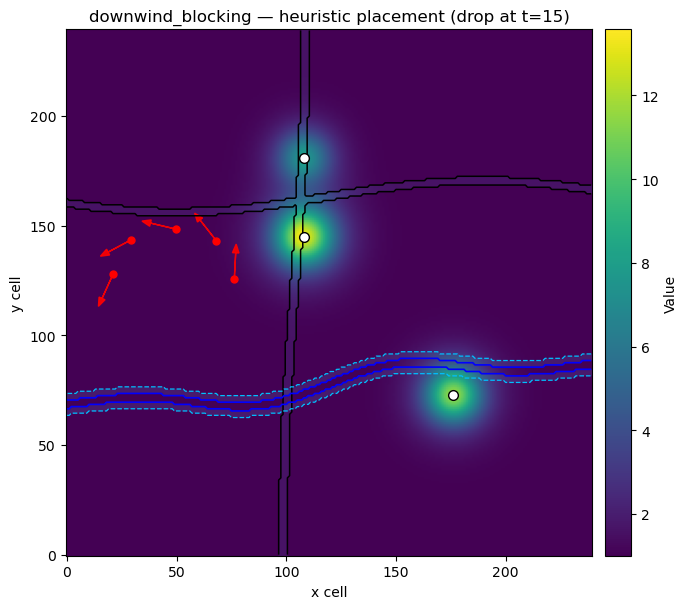

Applying retardant drop: D=[[ 20.947 127.755   3.568]
 [ 29.348 143.583   4.222]
 [ 49.743 148.402   4.945]
 [ 68.079 143.127   5.617]
 [ 76.275 125.609   0.054]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


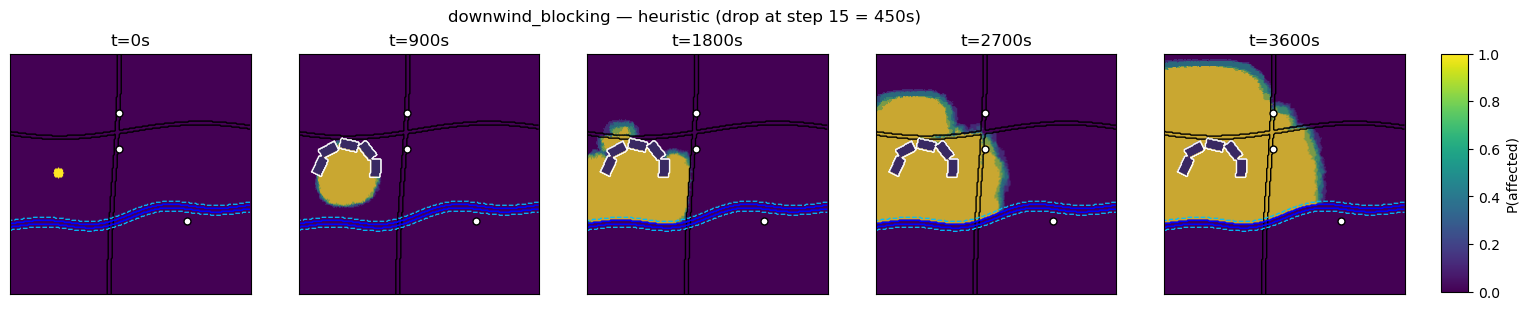

Running BO (random init) ...
No drone_params


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo_sr.py:575: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


BO init eval:   0%|          | 0/6 [00:00<?, ?it/s]

Applying retardant drop: D=[[ 30.123  95.045   3.494]
 [ 37.155 136.401   5.466]
 [ 41.103  85.572   5.004]
 [ 50.196 147.768   1.855]
 [ 65.591 126.493   0.889]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 23.321 103.408   1.304]
 [ 24.21   94.828   0.634]
 [ 29.138 140.727   3.658]
 [ 30.719 130.63    0.671]
 [ 60.171 101.793   2.468]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 27.686 107.353   2.849]
 [ 66.829 135.386   5.346]
 [ 69.102 129.773   2.591]
 [ 70.472 148.342   1.727]
 [ 76.884 103.611   5.324]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 14.913 114.596   2.297]
 [ 31.395 136.98    0.459]
 [ 55.015  85.202   4.274]
 [ 62.746 146.353   0.109]
 [ 63.3   104.055   5.165]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 36.293  84.432   4.007]
 [ 54.752 144.694   1.115]
 [ 55.777  84.8     6.236]
 [ 74.72  128.389   1.553]
 [ 76.174 129.62    1.92 ]], amount=2.0, drop

Bayesian optimisation:   0%|          | 0/6 [00:00<?, ?it/s]

Applying retardant drop: D=[[ 33.698  88.831   1.599]
 [ 39.721  93.322   5.496]
 [ 58.45  142.629   2.392]
 [ 63.906 106.265   0.197]
 [ 65.6   129.649   6.221]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 36.063  94.702   5.612]
 [ 41.324  87.901   1.468]
 [ 63.534 104.494   0.264]
 [ 66.473 129.037   0.021]
 [ 67.24  137.642   2.86 ]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 26.971 116.085   3.161]
 [ 70.338 129.494   5.754]
 [ 71.357 122.109   3.006]
 [ 71.853 145.292   1.812]
 [ 79.175 112.116   5.154]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 28.362 121.347   3.31 ]
 [ 70.724 116.936   3.236]
 [ 71.936 128.234   6.098]
 [ 77.786 135.504   2.154]
 [ 79.842 111.777   5.067]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 27.182 108.62    2.871]
 [ 69.855 147.764   1.771]
 [ 70.236 127.697   2.73 ]
 [ 72.173 123.4     5.894]
 [ 78.954 112.228   5.116]], amount=2.0, drop

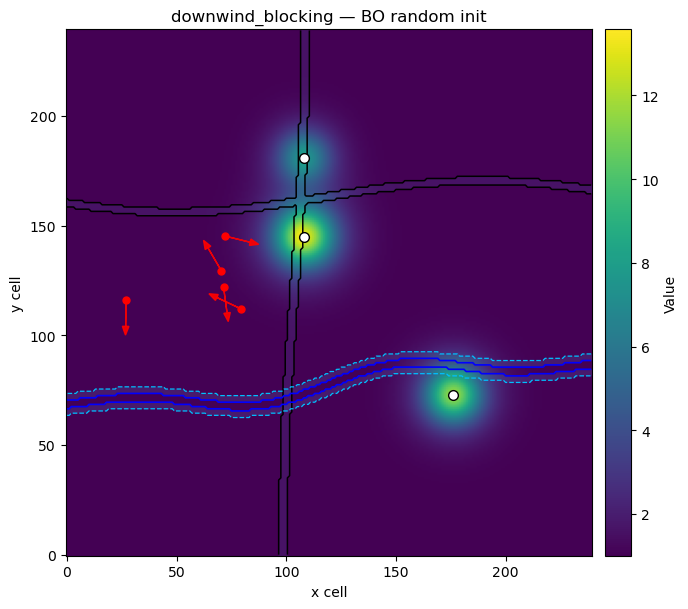

Applying retardant drop: D=[[ 26.971 116.085   3.161]
 [ 70.338 129.494   5.754]
 [ 71.357 122.109   3.006]
 [ 71.853 145.292   1.812]
 [ 79.175 112.116   5.154]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


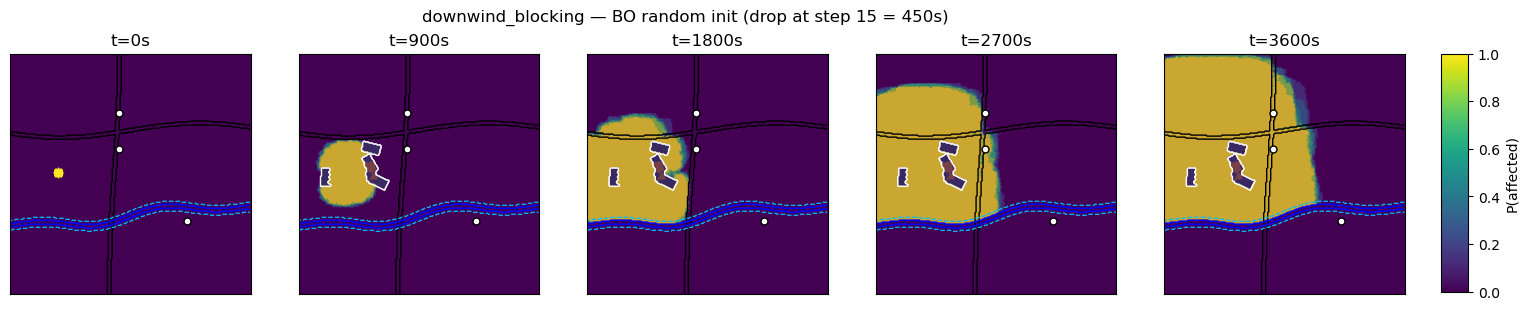

Running BO (heuristic init) ...
No drone_params


BO init eval:   0%|          | 0/6 [00:00<?, ?it/s]

Applying retardant drop: D=[[ 21.13  128.922   3.611]
 [ 30.3   144.174   4.257]
 [ 50.982 148.405   4.991]
 [ 68.906 142.367   5.655]
 [ 76.409 124.448   0.097]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 21.854 132.34    3.741]
 [ 33.407 145.656   4.363]
 [ 54.659 148.22    5.125]
 [ 71.098 139.814   5.77 ]
 [ 76.636 120.89    0.227]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 20.279 119.997   3.301]
 [ 23.712 100.63    2.704]
 [ 24.415 138.525   3.988]
 [ 41.032 147.628   4.623]
 [ 61.657 146.764   5.372]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 23.607 137.088   3.929]
 [ 39.201 147.296   4.558]
 [ 60.541 147.123   5.333]
 [ 73.833 134.909   5.973]
 [ 76.363 114.839   0.432]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 21.58  131.217   3.698]
 [ 32.333 145.209   4.327]
 [ 53.442 148.316   5.081]
 [ 70.415 140.707   5.731]
 [ 76.59  122.087   0.184]], amount=2.0, drop

Bayesian optimisation:   0%|          | 0/6 [00:00<?, ?it/s]

Applying retardant drop: D=[[ 36.868 146.522   4.364]
 [ 37.602 145.992   4.6  ]
 [ 57.81  146.979   5.233]
 [ 73.184 132.475   6.231]
 [ 73.911 132.642   6.215]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 19.087 126.603   3.519]
 [ 30.689 144.671   4.431]
 [ 66.669 144.843   5.515]
 [ 76.476 135.758   5.893]
 [ 76.519 120.917   0.144]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 22.689 137.242   3.788]
 [ 41.603 148.392   4.743]
 [ 57.733 149.148   5.272]
 [ 66.836 142.825   5.429]
 [ 77.809 120.619   0.259]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 21.804 125.573   3.535]
 [ 32.709 147.571   4.41 ]
 [ 53.02  148.877   5.011]
 [ 70.607 141.492   5.721]
 [ 75.172 114.776   0.291]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 21.035 132.223   3.569]
 [ 44.749 148.003   4.761]
 [ 45.31  147.189   4.606]
 [ 73.838 136.72    5.874]
 [ 74.505 115.1     0.383]], amount=2.0, drop

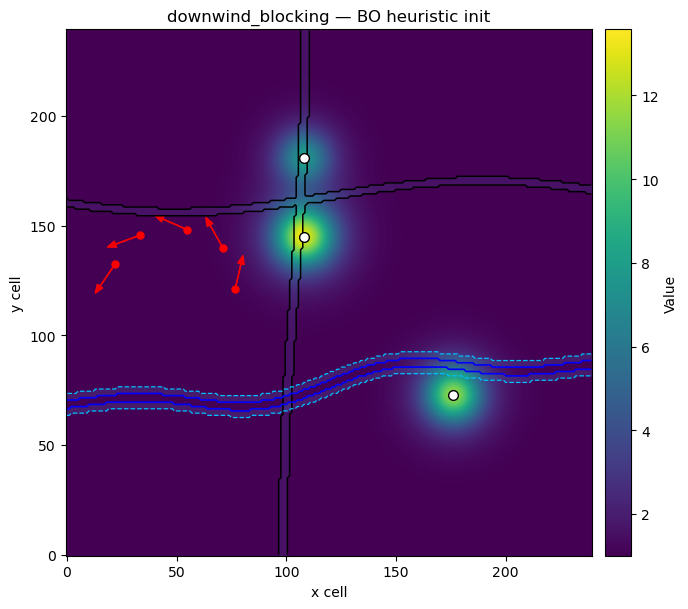

Applying retardant drop: D=[[ 21.854 132.34    3.741]
 [ 33.407 145.656   4.363]
 [ 54.659 148.22    5.125]
 [ 71.098 139.814   5.77 ]
 [ 76.636 120.89    0.227]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


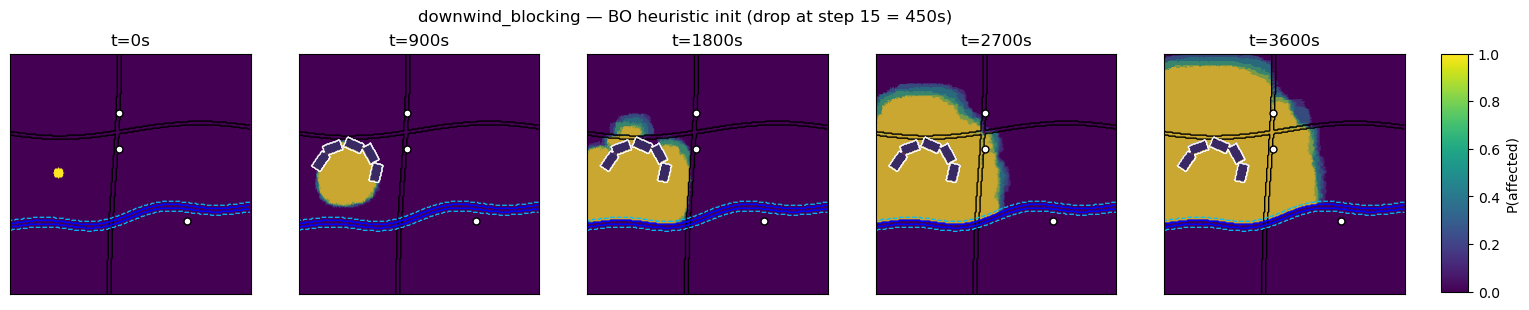


Case: uniform_ring | ignition: (120, 120)
EVOLUTION_TIME_S: 3600 s (1 hour)
No drone_params


Eval uniform_ring heuristic:   0%|          | 0/12 [00:00<?, ?it/s]

Applying retardant drop: D=[[100.759 131.389   4.07 ]
 [105.009  99.283   2.366]
 [123.663 150.936   4.92 ]
 [137.429  94.702   1.132]
 [148.1   129.42    6.168]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[105.804 108.03    4.761]
 [106.301 132.36    5.392]
 [127.128 102.142   1.44 ]
 [127.579 138.915   5.239]
 [137.627 122.528   0.994]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 97.644 126.229   3.862]
 [107.882  91.54    2.126]
 [115.661 153.012   4.679]
 [146.069  96.923   0.875]
 [149.431 138.682   5.876]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 99.4   122.013   3.792]
 [112.404  92.873   2.024]
 [113.293 148.248   4.636]
 [144.504 139.486   5.773]
 [145.059 103.22    0.787]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 99.974 120.567   3.759]
 [112.493 146.692   4.617]
 [113.388  93.708   2.008]
 [142.92  139.748   5.731]
 [144.332 104.696   0.772]], amount=2.0, drop

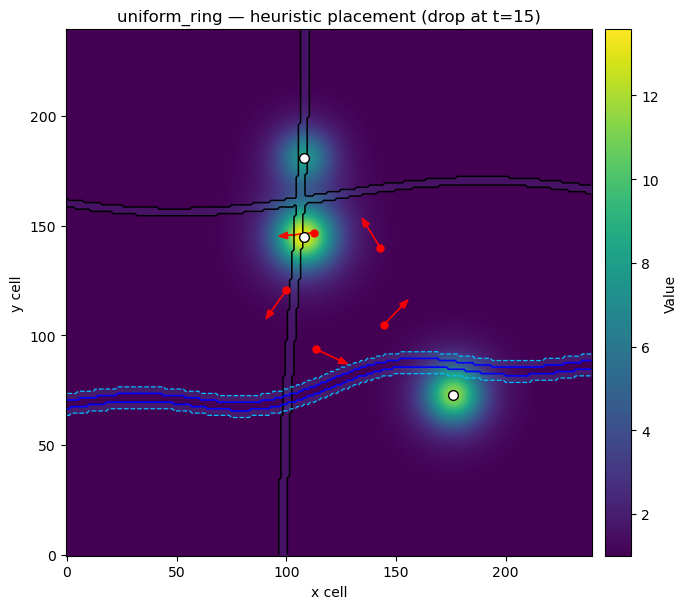

Applying retardant drop: D=[[ 99.974 120.567   3.759]
 [112.493 146.692   4.617]
 [113.388  93.708   2.008]
 [142.92  139.748   5.731]
 [144.332 104.696   0.772]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


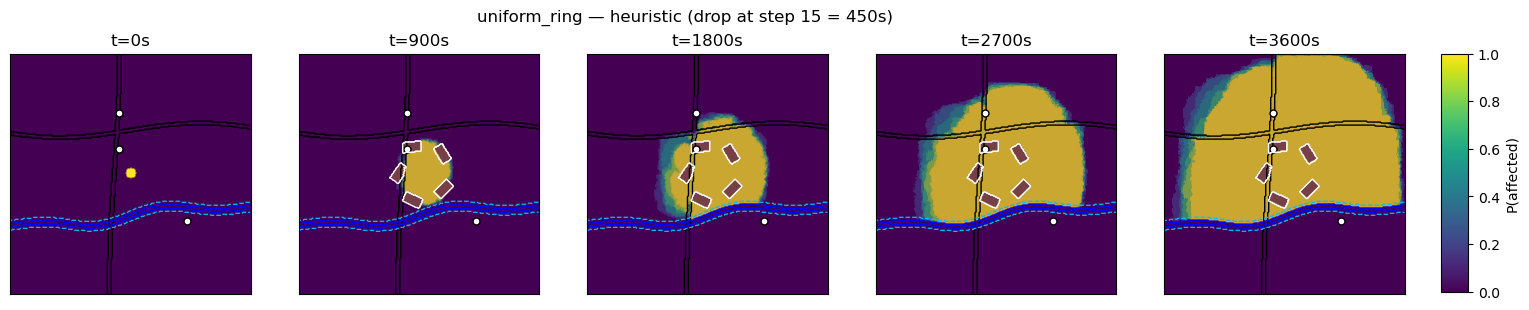

Running BO (random init) ...
No drone_params


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo_sr.py:575: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


BO init eval:   0%|          | 0/6 [00:00<?, ?it/s]

Applying retardant drop: D=[[100.996 109.464   3.769]
 [102.168 119.908   0.812]
 [102.344 118.443   0.997]
 [109.001 136.938   1.705]
 [151.474  95.909   2.643]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 97.335 125.316   1.534]
 [103.181 139.379   1.849]
 [135.018 144.814   4.26 ]
 [144.327 122.906   5.658]
 [155.086 124.32    2.582]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[105.709 140.892   5.1  ]
 [131.604 103.807   1.639]
 [138.265 111.718   4.735]
 [142.754 100.051   3.996]
 [147.853 104.483   0.331]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[103.81  114.669   1.844]
 [109.964 149.025   0.84 ]
 [110.158 147.665   4.298]
 [137.647 142.167   0.661]
 [139.345 123.661   5.782]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[102.655 139.444   1.441]
 [103.092 104.787   1.816]
 [110.267  95.438   2.791]
 [137.109  93.957   3.177]
 [150.55  107.721   5.944]], amount=2.0, drop

Bayesian optimisation:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Applying retardant drop: D=[[ 97.656 134.625   4.67 ]
 [ 97.826 120.982   1.524]
 [133.584 145.319   4.203]
 [144.868 117.741   5.889]
 [153.646 132.282   2.406]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[101.275 125.026   4.814]
 [105.632 135.571   3.199]
 [116.716 142.69    1.425]
 [116.871 101.121   1.246]
 [127.371 140.843   3.786]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Applying retardant drop: D=[[102.83  131.655   5.129]
 [102.933 128.485   2.972]
 [110.165 103.824   1.643]
 [118.798 141.701   1.47 ]
 [133.811 138.929   4.142]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[101.272 124.005   4.91 ]
 [106.993 138.571   3.138]
 [112.535 141.998   1.183]
 [114.109 101.716   1.205]
 [118.34  141.003   3.298]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[101.49  120.423   4.812]
 [108.751 136.72    4.002]
 [108.776 141.43    2.791]
 [110.304 141.069   1.542]
 [115.254 100.565   0.926]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[103.038 131.98    5.53 ]
 [105.901 136.695   4.054]
 [107.743 104.588   1.659]
 [117.604 143.291   1.375]
 [119.114 139.636   0.208]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[101.275 125.026   4.814]
 [105.632 135.571   3.199]
 [116.716 142.69    1.425]
 [116.871 101.121   1.246]
 [127.371 140.843   3.786]], amount=2.0, drop

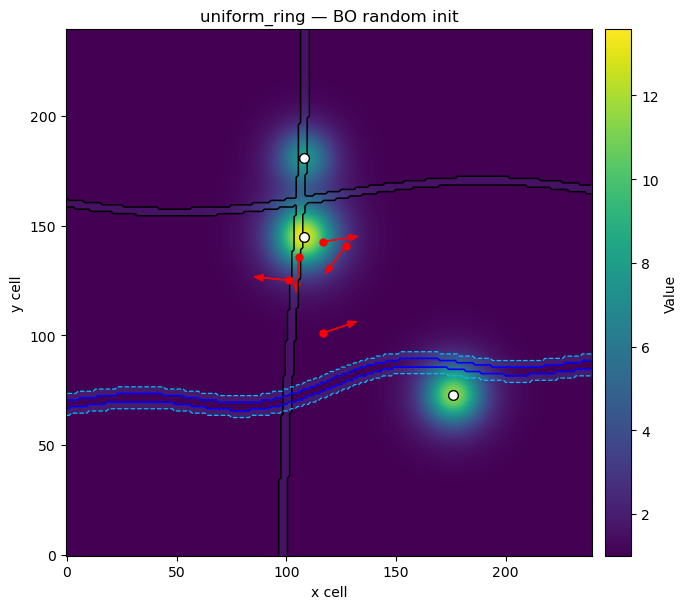

Applying retardant drop: D=[[101.275 125.026   4.814]
 [105.632 135.571   3.199]
 [116.716 142.69    1.425]
 [116.871 101.121   1.246]
 [127.371 140.843   3.786]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


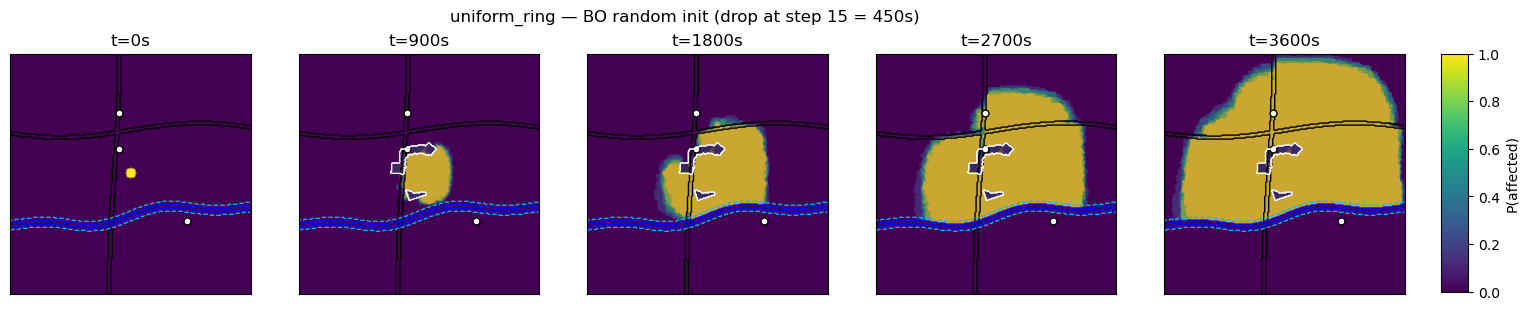

Running BO (heuristic init) ...
No drone_params


BO init eval:   0%|          | 0/6 [00:00<?, ?it/s]

Applying retardant drop: D=[[ 99.518 122.443   3.808]
 [112.03   93.319   2.04 ]
 [113.772 148.293   4.647]
 [144.285 139.363   5.773]
 [144.586 102.921   0.802]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[100.333 104.191   2.766]
 [102.216 138.239   4.279]
 [131.919 154.199   5.122]
 [132.136  87.738   1.373]
 [153.518 122.231   0.117]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 99.89  123.184   3.838]
 [111.435  94.423   2.071]
 [114.762 148.1     4.669]
 [143.138 102.108   0.847]
 [144.277 137.6     5.836]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[103.86  128.875   4.115]
 [107.472 103.391   2.443]
 [123.53  143.719   4.975]
 [133.13  100.749   1.196]
 [140.599 127.24    6.231]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 97.821 116.541   3.553]
 [108.15  147.088   4.508]
 [117.014  86.726   1.847]
 [144.109 147.609   5.527]
 [151.512 106.282   0.615]], amount=2.0, drop

Bayesian optimisation:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Applying retardant drop: D=[[ 99.749 117.204   4.647]
 [103.425 134.118   4.752]
 [137.166 155.41    3.811]
 [137.863 126.347   5.255]
 [140.985 131.78    6.102]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 98.945 120.244   3.707]
 [111.126 146.929   4.459]
 [115.687  92.301   1.982]
 [141.59  141.845   5.578]
 [145.885 103.958   0.789]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Applying retardant drop: D=[[101.007 114.686   3.561]
 [111.629 146.399   4.68 ]
 [115.117  92.335   2.064]
 [143.381  98.352   0.977]
 [146.831 135.724   5.984]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Applying retardant drop: D=[[ 99.509 115.294   3.465]
 [109.85  146.82    4.526]
 [112.29   93.83    2.064]
 [131.832  92.464   1.357]
 [136.454 145.052   5.441]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Applying retardant drop: D=[[ 99.7   122.82    3.865]
 [108.522 142.842   4.522]
 [110.309  96.44    2.028]
 [137.961 146.061   5.423]
 [143.731 103.038   0.813]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Applying retardant drop: D=[[ 99.747 116.703   3.629]
 [104.826 135.933   4.267]
 [116.548  93.094   1.737]
 [138.662 146.067   5.398]
 [144.905 105.615   0.69 ]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 99.7   122.82    3.865]
 [108.522 142.842   4.522]
 [110.309  96.44    2.028]
 [137.961 146.061   5.423]
 [143.731 103.038   0.813]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
[BO heuristic] expected value burned @1h: 116.616


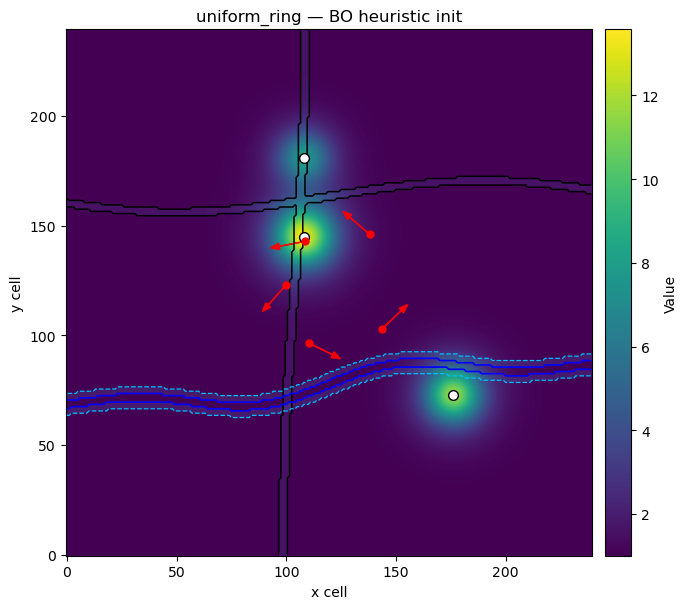

Applying retardant drop: D=[[ 99.7   122.82    3.865]
 [108.522 142.842   4.522]
 [110.309  96.44    2.028]
 [137.961 146.061   5.423]
 [143.731 103.038   0.813]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


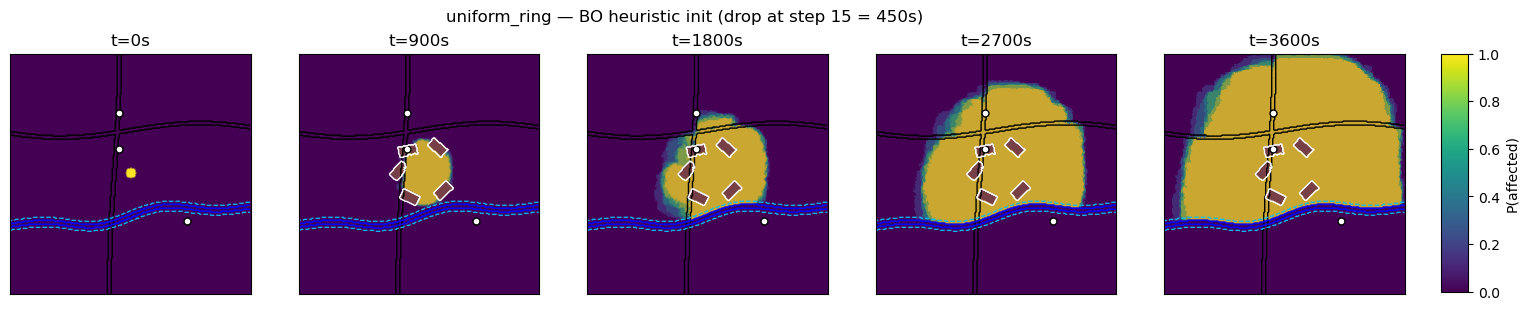


Case: value_blocking | ignition: (115, 100)
EVOLUTION_TIME_S: 3600 s (1 hour)
No drone_params


Eval value_blocking heuristic:   0%|          | 0/12 [00:00<?, ?it/s]

Applying retardant drop: D=[[111.704 130.152   4.192]
 [129.999  83.558   6.098]
 [130.631 129.913   4.764]
 [144.612 116.227   5.4  ]
 [146.717  94.589   5.924]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[105.941 123.121   4.824]
 [140.424 121.003   4.414]
 [141.119 124.606   4.805]
 [141.328 126.305   0.76 ]
 [149.935 109.647   5.988]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 92.967 108.868   3.5  ]
 [102.28  122.41    3.939]
 [115.422 131.719   4.304]
 [134.777 127.979   4.926]
 [146.068 111.548   5.518]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[106.785 126.592   4.032]
 [122.555 132.513   4.506]
 [138.735  86.797   6.054]
 [140.437 123.247   5.177]
 [147.908 102.748   5.741]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 95.259  85.449   5.884]
 [ 98.55  103.004   3.484]
 [118.265 130.093   1.662]
 [119.414 121.634   5.672]
 [144.602 120.697   2.934]], amount=2.0, drop

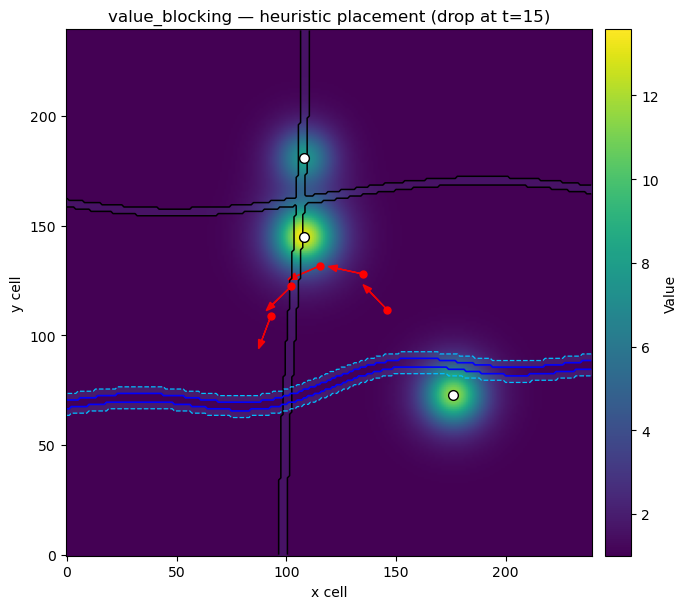

Applying retardant drop: D=[[ 92.967 108.868   3.5  ]
 [102.28  122.41    3.939]
 [115.422 131.719   4.304]
 [134.777 127.979   4.926]
 [146.068 111.548   5.518]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


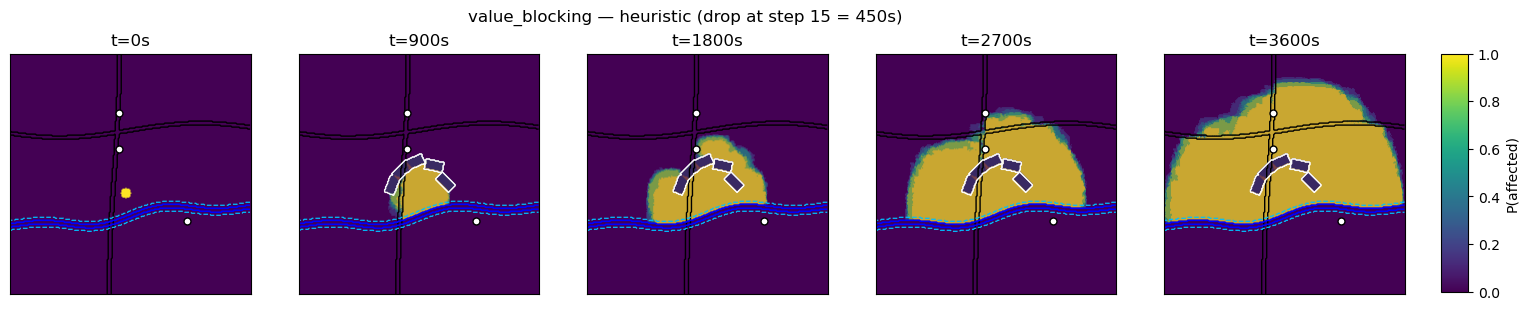

Running BO (random init) ...
No drone_params


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo_sr.py:575: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


BO init eval:   0%|          | 0/6 [00:00<?, ?it/s]

Applying retardant drop: D=[[ 96.506 100.417   0.703]
 [ 99.699  81.082   1.63 ]
 [101.024 110.39    3.96 ]
 [133.712 131.642   0.915]
 [145.49  111.725   2.043]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 91.463 101.374   2.383]
 [103.509 126.221   3.314]
 [126.723  83.004   6.061]
 [128.287  83.309   5.956]
 [138.301 108.539   6.155]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[100.862 105.909   0.842]
 [114.413  79.433   0.24 ]
 [117.311  80.614   3.328]
 [126.507  82.962   2.057]
 [133.015  85.694   0.231]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 87.764 108.82    0.988]
 [ 92.943  97.316   4.449]
 [ 97.421 122.123   5.473]
 [126.241 130.464   3.239]
 [127.134 133.597   1.843]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[105.826 126.379   3.762]
 [119.672 120.75    5.367]
 [130.474  83.551   5.579]
 [135.851 118.653   4.782]
 [138.781  89.733   0.302]], amount=2.0, drop

Bayesian optimisation:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Applying retardant drop: D=[[ 91.971 117.012   1.453]
 [ 93.611 100.073   4.508]
 [ 96.563 121.797   5.545]
 [120.296 134.545   1.579]
 [131.661 129.037   3.487]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[105.987 126.87    3.905]
 [120.056  79.82    0.221]
 [121.737 120.04    2.019]
 [139.102  90.731   0.294]
 [139.429 111.225   5.038]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Applying retardant drop: D=[[113.32  131.367   3.996]
 [122.03   80.561   6.144]
 [125.98  118.515   2.465]
 [136.479 115.343   4.848]
 [140.853  97.534   0.166]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[104.779 125.63    3.6  ]
 [119.857 120.51    1.238]
 [134.467  85.802   0.429]
 [139.69  111.562   5.141]
 [147.18   91.973   5.602]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[104.354 124.264   3.659]
 [117.491 120.241   5.237]
 [129.467 124.411   4.487]
 [140.767  94.337   0.067]
 [144.096  88.749   5.48 ]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[109.775 128.699   3.499]
 [117.491 120.241   5.004]
 [119.442 126.865   4.071]
 [139.587  95.059   0.006]
 [147.914  92.128   5.192]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[105.826 126.379   3.762]
 [119.672 120.75    5.367]
 [130.474  83.551   5.579]
 [135.851 118.653   4.782]
 [138.781  89.733   0.302]], amount=2.0, drop

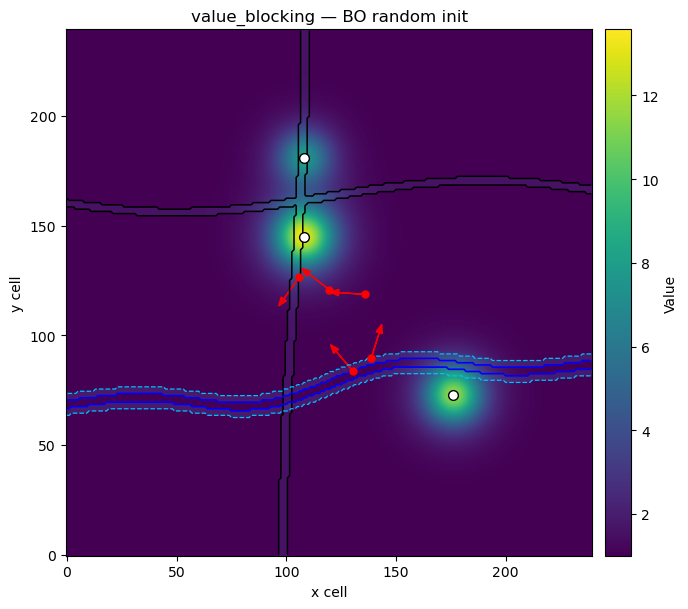

Applying retardant drop: D=[[105.826 126.379   3.762]
 [119.672 120.75    5.367]
 [130.474  83.551   5.579]
 [135.851 118.653   4.782]
 [138.781  89.733   0.302]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


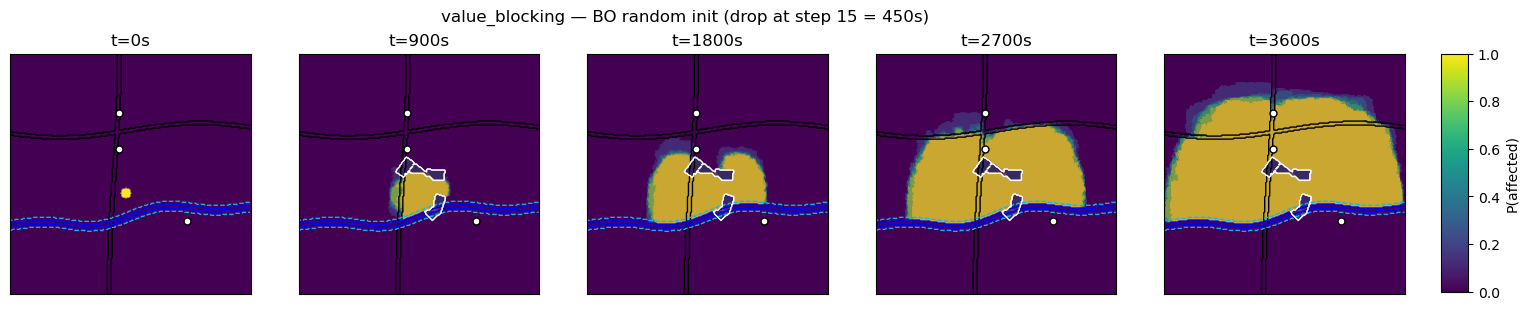

Running BO (heuristic init) ...
No drone_params


BO init eval:   0%|          | 0/6 [00:00<?, ?it/s]

Applying retardant drop: D=[[ 91.281  89.748   2.854]
 [ 92.703 109.591   3.521]
 [102.921  77.738   2.358]
 [121.458  80.73    0.287]
 [142.64   89.074   6.028]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 97.005 123.809   4.713]
 [ 98.7    95.399   2.906]
 [111.288 129.896   4.179]
 [123.261 135.119   4.386]
 [144.19  116.54    5.385]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[109.431 131.027   4.409]
 [110.404 124.717   4.107]
 [120.967 128.156   4.482]
 [124.302 129.106   4.492]
 [136.447  85.556   5.695]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[103.68  123.813   3.958]
 [116.895 132.284   4.348]
 [136.193 126.975   4.987]
 [143.683  89.821   6.017]
 [146.752 109.983   5.563]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[ 90.293  88.867   2.734]
 [ 92.175 105.457   3.459]
 [110.809 134.871   1.936]
 [116.004  78.724   0.833]
 [127.443 122.541   5.65 ]], amount=2.0, drop

Bayesian optimisation:   0%|          | 0/6 [00:00<?, ?it/s]

Applying retardant drop: D=[[ 99.851 120.768   4.009]
 [115.422 131.719   4.239]
 [129.551 131.274   4.708]
 [144.291  90.25    5.997]
 [144.546 117.853   5.358]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[104.202 124.429   3.788]
 [114.429 131.418   4.361]
 [133.835 128.855   4.922]
 [141.08   88.091   6.025]
 [144.331 114.281   5.433]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[106.355 126.424   3.878]
 [116.76  132.639   4.427]
 [134.133 130.553   5.031]
 [142.989 114.25    5.52 ]
 [143.26   89.236   5.936]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Applying retardant drop: D=[[108.013 127.956   3.686]
 [113.425 131.158   4.365]
 [128.409 131.401   4.676]
 [145.211 104.723   5.676]
 [147.791 102.678   5.607]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Applying retardant drop: D=[[114.021 132.289   4.218]
 [121.13  133.631   4.535]
 [132.701 128.643   4.932]
 [134.338 128.552   5.043]
 [147.609  95.387   5.814]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Applying retardant drop: D=[[105.822 125.721   3.873]
 [118.197 131.823   4.476]
 [138.125  86.655   6.058]
 [142.867 120.079   5.451]
 [147.569 106.444   5.612]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
Applying retardant drop: D=[[104.202 124.429   3.788]
 [114.429 131.418   4.361]
 [133.835 128.855   4.922]
 [141.08   88.091   6.025]
 [144.331 114.281   5.433]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9
[BO heuristic] expected value burned @1h: 101.45


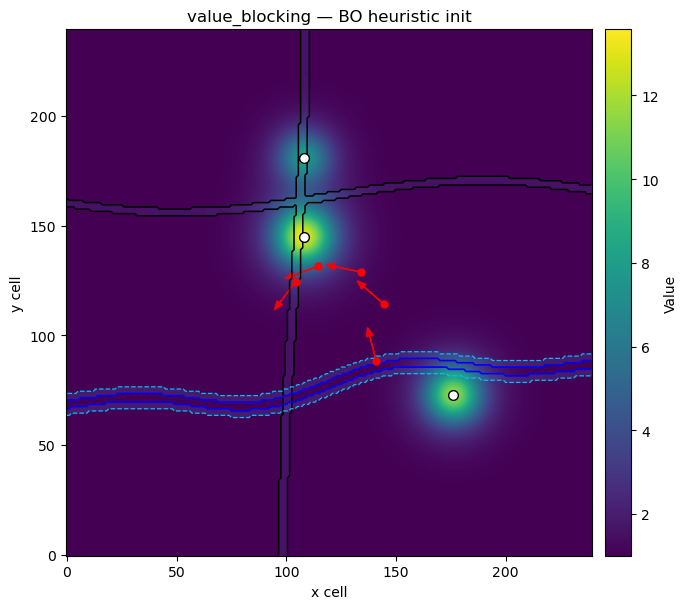

Applying retardant drop: D=[[104.202 124.429   3.788]
 [114.429 131.418   4.361]
 [133.835 128.855   4.922]
 [141.08   88.091   6.025]
 [144.331 114.281   5.433]], amount=2.0, drop_w_km=0.5, drop_h_km=0.9


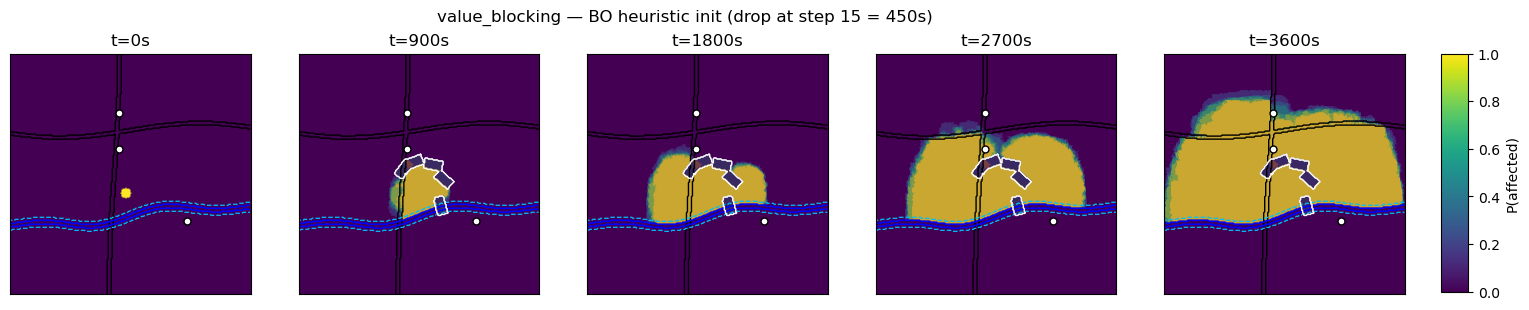

dict_keys(['downwind_blocking', 'uniform_ring', 'value_blocking'])

In [21]:
def plot_placements_on_value(env, params_xyphi, *, overlays=None, title=""):
    overlays = overlays or {}
    road_mask = overlays.get('road_mask', None)
    river_mask = overlays.get('river_mask', None)
    riparian_mask = overlays.get('riparian_mask', None)
    town_centers = overlays.get('town_centers', [])

    fig, ax = plt.subplots(figsize=(7.2, 6.2))
    im = ax.imshow(env.value.T, origin='lower')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02, label='Value')

    if road_mask is not None:
        ax.contour(road_mask.T.astype(float), levels=[0.5], linewidths=1.1, colors='k')
    if riparian_mask is not None:
        ax.contour(riparian_mask.T.astype(float), levels=[0.5], linewidths=0.9, colors='deepskyblue', linestyles='--')
    if river_mask is not None:
        ax.contour(river_mask.T.astype(float), levels=[0.5], linewidths=1.2, colors='blue')
    for (ti, tj) in town_centers:
        ax.plot(ti, tj, 'wo', ms=7, mec='k')

    # plot drops
    if params_xyphi is not None and len(params_xyphi) > 0:
        for (x, y, phi) in params_xyphi:
            ax.plot(x, y, 'r.', ms=10)
            # draw a short arrow showing long-axis direction
            dx = 12 * np.sin(phi)
            dy = 12 * np.cos(phi)
            ax.arrow(x, y, dx, dy, head_width=3.0, head_length=4.0, fc='r', ec='r', alpha=0.9)

    ax.set_title(title)
    ax.set_xlabel('x cell'); ax.set_ylabel('y cell')
    plt.tight_layout()
    plt.show()


HEURISTIC_CONFIGS = {
    'downwind_blocking': dict(
        init_strategy='downwind_line',
        init_heuristic_kwargs=dict(r_value=0.70, jitter_r=0.02, center_jitter_cells=6.0),
    ),
    'uniform_ring': dict(
        init_strategy='uniform_ring',
        init_heuristic_kwargs=dict(r_min=0.65, r_max=0.65, jitter_s=0.02, jitter_r=0.02),
    ),
    'value_blocking': dict(
        init_strategy='heuristic',
        init_heuristic_kwargs=dict(value_power=1.0, r_offset=0.05, jitter_s=0.02, jitter_delta_rad=np.deg2rad(8.0)),
    ),
}

BO_N_INIT = 6
BO_N_ITERS = 6
BO_N_CAND = 1200

RESULTS = {}

for name, ignition in IGNITIONS.items():
    print('\n' + '='*90)
    print('Case:', name, '| ignition:', ignition)
    print('EVOLUTION_TIME_S:', EVOLUTION_TIME_S, 's (1 hour)')

    opt = make_opt_sr_for_ignition(ignition, seed=SEED)

    # Ensure SR grid exists (also validates mask / decode)
    opt.setup_search_grid_sr(K=320, boundary_field='affected')

    cfg = HEURISTIC_CONFIGS[name]

    # --- Heuristic-only: sample a bunch and take the best ---
    n_samples = 12
    thetas = opt.sample_initial_thetas(
        n_samples,
        strategy=cfg['init_strategy'],
        heuristic_kwargs=cfg['init_heuristic_kwargs'],
    )
    thetas = np.atleast_2d(thetas)

    ys = np.array([opt.expected_value_burned_area(th) for th in tqdm(thetas, desc=f"Eval {name} heuristic")], float)
    best_theta_h = thetas[int(np.argmin(ys))]
    best_obj_h_1h = float(opt.expected_value_burned_area(best_theta_h))
    print('[Heuristic] expected value burned @1h:', f'{best_obj_h_1h:.6g}')
    best_obj_h = float(np.min(ys))

    print('Best heuristic objective:', best_obj_h)

    params_xyphi = opt.decode_theta(best_theta_h)
    RESULTS[name] = dict(theta=best_theta_h, obj=best_obj_h, params_xyphi=params_xyphi, opt=opt)

    plot_placements_on_value(env, params_xyphi, overlays=overlays, title=f"{name} — heuristic placement (drop at t=15)")

    plot_fire_evolution_with_context_dropstep(
        opt.fire_model,
        ignition,
        T_s=EVOLUTION_TIME_S,
        n_sims=N_SIMS_LOW,
        drop_step=DROP_STEP,
        drone_params_xyphi=params_xyphi,
        dt_snapshot_s=15*60,
        overlays=overlays,
        title_prefix=f"{name} — heuristic",
    )

    # --- BO: random init ---
    print('Running BO (random init) ...')
    best_theta_rand, hist_rand = run_bayes_opt_sr(
        opt,
        n_init=BO_N_INIT,
        n_iters=BO_N_ITERS,
        n_candidates=BO_N_CAND,
        init_strategy='random',
        init_heuristic_kwargs=None,
        seed=SEED,
    )

    params_xyphi_rand = opt.decode_theta(best_theta_rand)
    best_obj_rand_1h = float(opt.expected_value_burned_area(best_theta_rand))
    print('[BO random] expected value burned @1h:', f'{best_obj_rand_1h:.6g}')
    RESULTS[name]['bo_random'] = dict(theta=best_theta_rand, hist=hist_rand, params_xyphi=params_xyphi_rand)

    plot_placements_on_value(env, params_xyphi_rand, overlays=overlays, title=f"{name} — BO random init")

    plot_fire_evolution_with_context_dropstep(
        opt.fire_model,
        ignition,
        T_s=EVOLUTION_TIME_S,
        n_sims=N_SIMS_LOW,
        drop_step=DROP_STEP,
        drone_params_xyphi=params_xyphi_rand,
        dt_snapshot_s=15*60,
        overlays=overlays,
        title_prefix=f"{name} — BO random init",
    )

    # --- BO: heuristic init ---
    print('Running BO (heuristic init) ...')
    best_theta_heur, hist_heur = run_bayes_opt_sr(
        opt,
        n_init=BO_N_INIT,
        n_iters=BO_N_ITERS,
        n_candidates=BO_N_CAND,
        init_strategy=cfg['init_strategy'],
        init_heuristic_kwargs=cfg['init_heuristic_kwargs'],
        seed=SEED,
    )

    params_xyphi_heur = opt.decode_theta(best_theta_heur)
    best_obj_heur_1h = float(opt.expected_value_burned_area(best_theta_heur))
    print('[BO heuristic] expected value burned @1h:', f'{best_obj_heur_1h:.6g}')
    RESULTS[name]['bo_heuristic'] = dict(theta=best_theta_heur, hist=hist_heur, params_xyphi=params_xyphi_heur)

    plot_placements_on_value(env, params_xyphi_heur, overlays=overlays, title=f"{name} — BO heuristic init")

    plot_fire_evolution_with_context_dropstep(
        opt.fire_model,
        ignition,
        T_s=EVOLUTION_TIME_S,
        n_sims=N_SIMS_LOW,
        drop_step=DROP_STEP,
        drone_params_xyphi=params_xyphi_heur,
        dt_snapshot_s=15*60,
        overlays=overlays,
        title_prefix=f"{name} — BO heuristic init",
    )

RESULTS.keys()

## BO convergence (important for report)
Plot best objective over BO iterations for random vs heuristic init (per scenario).


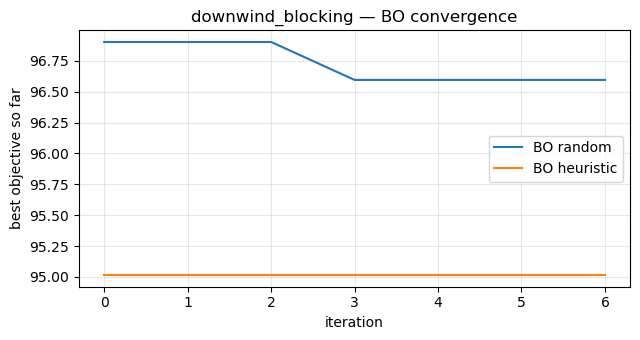

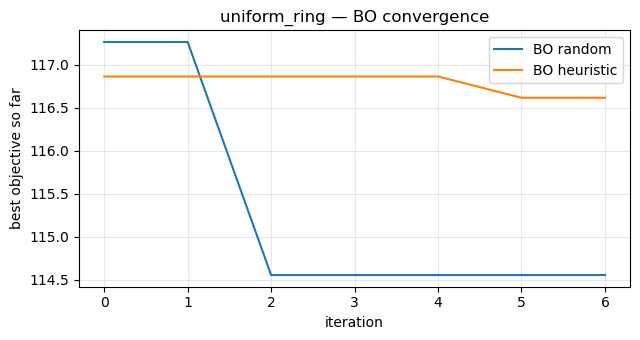

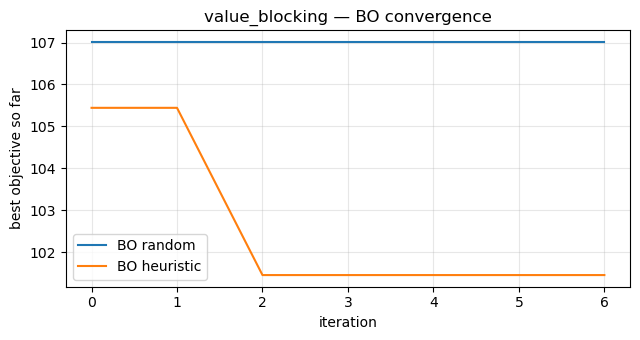

In [22]:
for name, data in RESULTS.items():
    plt.figure(figsize=(6.5, 3.5))
    if 'bo_random' in data:
        plt.plot(data['bo_random']['hist']['y_best'], label='BO random')
    if 'bo_heuristic' in data:
        plt.plot(data['bo_heuristic']['hist']['y_best'], label='BO heuristic')
    plt.title(f"{name} — BO convergence")
    plt.xlabel('iteration')
    plt.ylabel('best objective so far')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
